# Pipeline Template

In [1]:
%load_ext autoreload 
%autoreload 1

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler, MatrixFactorization

%aimport util.data

C:\Users\nicok\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading Dataset

In [3]:
train_data, test_data = util.data.load()

Training Data: 
  Amount of features: 888
  Amount of observations: 1212
  Min age: 42.0 Max age: 96.0

Test Data: 
  Amount of observations: 776


# Preprocessing

## Fill Missing Values (Remove NaNs)

use one of the methods to fill the missing values

In [ ]:
X_incomplete = train_data.drop(["id", "y"], axis=1).values
y = train_data["y"].values

#### k-nearest neighbors

In [ ]:
k = 12

# Use nearest rows which have a feature to fill in each row's missing features
X = KNN(k=k).fit_transform(X_incomplete)

#### singular values thresholding

In [ ]:
# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
X_incomplete_normalized = BiScaler().fit_transform(X_incomplete)
X = SoftImpute().fit_transform(X_incomplete_normalized)

#### use matrix factorization

In [ ]:
X = MatrixFactorization(learning_rate= 0.001, rank=40).fit_transform(X_incomplete)

#### mean

In [ ]:
train_mean_values = train_data.mean()
train_data_mean =  train_data.fillna(train_mean_values)
X = train_data_mean.drop(["id", "y"], axis=1).values

## Data Normalization / Standardization

use one of the methods provided to normalize the data (expects no NaNs)

[Compare the effect of different scalers on data with outliers](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

#### L1 - Normalization 

In [ ]:
X = normalize(X, axis=0, norm='l1')

#### L2 - Normalization 

In [ ]:
X = normalize(X, axis=0, norm='l2')

#### Standard Scalar
removes mean and divides by std (**sensitive to outliers** => probably not a good idea)

In [ ]:
X = StandardScaler().fit_transform(X)

#### Robust Scaler
Scale features using statistics that are robust to outliers. [scikit doc](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)



In [ ]:
X = RobustScaler(quantile_range=(10, 90)).fit_transform(X)

## Outlier Detection and Removal

## Feature Selection

In [ ]:
estimator = RandomForestRegressor(n_jobs=-1, n_estimators=50)

In [ ]:
estimator = RandomForestRegressor(n_jobs=-1, n_estimators=50)

In [ ]:
# Feature Selection with Recursive Feature Elimination with Cross Validation (RFECV)

n_rm_features_per_iteration = 4
cv_k = 3



rfecv = RFECV(estimator, step=n_rm_features_per_iteration, cv=cv_k, scoring='r2', verbose=1)

rfecv.fit(X, y)


In [ ]:
print("Optimal number of features : %d" % rfecv.n_features_) #47
print(f"Validation Score: {max(rfecv.grid_scores_)}")

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, n_rm_features_per_iteration * len(rfecv.grid_scores_) + 1, n_rm_features_per_iteration), rfecv.grid_scores_)
plt.show()

selected_feature_cols = train_data.columns.values[1:-1][rfecv.support_]

print('Selected Features: ')
print(selected_feature_cols)

# Model Selection

#### K-Fold Cross Validation

In [4]:
selected_feature_cols = ['x0', 'x42', 'x80', 'x82', 'x89', 'x94', 'x96', 'x120', 'x137', 'x178', 'x185',
 'x186', 'x192', 'x224', 'x234', 'x237', 'x264', 'x273', 'x280', 'x291', 'x300',
 'x309', 'x320', 'x328', 'x331', 'x333', 'x340', 'x349', 'x391', 'x400', 'x424',
 'x426', 'x449', 'x450', 'x470', 'x479', 'x499', 'x520', 'x529', 'x536', 'x547',
 'x555', 'x559', 'x604', 'x618', 'x644', 'x651', 'x658', 'x664', 'x673', 'x685',
 'x686', 'x687', 'x722', 'x730', 'x739', 'x743', 'x746', 'x751', 'x800', 'x810',
 'x871', 'x882']

In [8]:
k = 20

X_sel_incomplete= train_data[selected_feature_cols].values
X_sel =  KNN(k=k).fit_transform(X_sel_incomplete)
X_sel = RobustScaler(quantile_range=(10, 90)).fit_transform(X_sel)
y_sel = train_data["y"].values


#pca = PCA(n_components=100, whiten=False)
#X_sel = pca.fit_transform(X)
#y_sel = y

estimator = MLPRegressor(learning_rate='constant', 
                        hidden_layer_sizes=(60, 40),
                         activation='logistic', 
                         learning_rate_init=0.0001, 
                         max_iter=15000, 
                         early_stopping =True,
                         validation_fraction=0.1,
                         tol=0.000000001,
                        alpha=0.8,
                         #n_iter_no_change=10,
                         verbose=True)

estimator.fit(X_sel,y_sel)
estimator.score(X_sel,y_sel)

#score = cross_val_score((estimator), X_sel, y_sel, scoring='r2', cv=4)
#print(score.mean())


Imputing row 1/1212 with 4 missing, elapsed time: 1.926
Imputing row 101/1212 with 6 missing, elapsed time: 1.945
Imputing row 201/1212 with 8 missing, elapsed time: 1.965
Imputing row 301/1212 with 5 missing, elapsed time: 1.987
Imputing row 401/1212 with 3 missing, elapsed time: 2.009
Imputing row 501/1212 with 2 missing, elapsed time: 2.027
Imputing row 601/1212 with 4 missing, elapsed time: 2.045
Imputing row 701/1212 with 5 missing, elapsed time: 2.060
Imputing row 801/1212 with 2 missing, elapsed time: 2.078
Imputing row 901/1212 with 2 missing, elapsed time: 2.094
Imputing row 1001/1212 with 5 missing, elapsed time: 2.113
Imputing row 1101/1212 with 3 missing, elapsed time: 2.136
Imputing row 1201/1212 with 5 missing, elapsed time: 2.162
Iteration 1, loss = 2473.89376136
Validation score: -48.807447
Iteration 2, loss = 2471.63114166
Validation score: -48.763340
Iteration 3, loss = 2469.37776481
Validation score: -48.719310
Iteration 4, loss = 2467.11757423
Validation score: -48.

Iteration 125, loss = 2231.54180088
Validation score: -44.065131
Iteration 126, loss = 2229.96155449
Validation score: -44.034395
Iteration 127, loss = 2228.37956369
Validation score: -44.003672
Iteration 128, loss = 2226.80356074
Validation score: -43.972984
Iteration 129, loss = 2225.22282534
Validation score: -43.942339
Iteration 130, loss = 2223.64672274
Validation score: -43.911716
Iteration 131, loss = 2222.06911948
Validation score: -43.881134
Iteration 132, loss = 2220.49699998
Validation score: -43.850575
Iteration 133, loss = 2218.92327239
Validation score: -43.820069
Iteration 134, loss = 2217.35195246
Validation score: -43.789588
Iteration 135, loss = 2215.78297985
Validation score: -43.759138
Iteration 136, loss = 2214.21833523
Validation score: -43.728679
Iteration 137, loss = 2212.65021434
Validation score: -43.698299
Iteration 138, loss = 2211.08262137
Validation score: -43.667961
Iteration 139, loss = 2209.52064199
Validation score: -43.637611
Iteration 140, loss = 220

Iteration 264, loss = 2042.15211046
Validation score: -40.397571
Iteration 265, loss = 2040.97642442
Validation score: -40.374830
Iteration 266, loss = 2039.80463100
Validation score: -40.352095
Iteration 267, loss = 2038.63290363
Validation score: -40.329351
Iteration 268, loss = 2037.46147163
Validation score: -40.306598
Iteration 269, loss = 2036.28937110
Validation score: -40.283836
Iteration 270, loss = 2035.11923294
Validation score: -40.261069
Iteration 271, loss = 2033.94634091
Validation score: -40.238328
Iteration 272, loss = 2032.77518719
Validation score: -40.215605
Iteration 273, loss = 2031.60553405
Validation score: -40.192855
Iteration 274, loss = 2030.43186653
Validation score: -40.170111
Iteration 275, loss = 2029.25980415
Validation score: -40.147342
Iteration 276, loss = 2028.08799536
Validation score: -40.124517
Iteration 277, loss = 2026.91121410
Validation score: -40.101685
Iteration 278, loss = 2025.73695039
Validation score: -40.078803
Iteration 279, loss = 202

Iteration 391, loss = 1898.02404148
Validation score: -37.595237
Iteration 392, loss = 1896.95620903
Validation score: -37.574408
Iteration 393, loss = 1895.88642094
Validation score: -37.553580
Iteration 394, loss = 1894.81671769
Validation score: -37.532729
Iteration 395, loss = 1893.74442106
Validation score: -37.511911
Iteration 396, loss = 1892.67536193
Validation score: -37.491061
Iteration 397, loss = 1891.60386780
Validation score: -37.470212
Iteration 398, loss = 1890.53259975
Validation score: -37.449314
Iteration 399, loss = 1889.45929954
Validation score: -37.428386
Iteration 400, loss = 1888.38456940
Validation score: -37.407438
Iteration 401, loss = 1887.30823559
Validation score: -37.386475
Iteration 402, loss = 1886.23058792
Validation score: -37.365473
Iteration 403, loss = 1885.15294634
Validation score: -37.344434
Iteration 404, loss = 1884.07218229
Validation score: -37.323393
Iteration 405, loss = 1882.99344781
Validation score: -37.302314
Iteration 406, loss = 188

Iteration 531, loss = 1738.58695831
Validation score: -34.482035
Iteration 532, loss = 1737.52348266
Validation score: -34.461276
Iteration 533, loss = 1736.45952247
Validation score: -34.440542
Iteration 534, loss = 1735.39954143
Validation score: -34.419794
Iteration 535, loss = 1734.33910718
Validation score: -34.399082
Iteration 536, loss = 1733.27654227
Validation score: -34.378405
Iteration 537, loss = 1732.21933522
Validation score: -34.357730
Iteration 538, loss = 1731.16189845
Validation score: -34.337072
Iteration 539, loss = 1730.10386890
Validation score: -34.316454
Iteration 540, loss = 1729.05061289
Validation score: -34.295845
Iteration 541, loss = 1727.99627920
Validation score: -34.275265
Iteration 542, loss = 1726.94204921
Validation score: -34.254726
Iteration 543, loss = 1725.88984160
Validation score: -34.234208
Iteration 544, loss = 1724.83787443
Validation score: -34.213690
Iteration 545, loss = 1723.78800677
Validation score: -34.193161
Iteration 546, loss = 172

Iteration 664, loss = 1591.66143564
Validation score: -31.605369
Iteration 665, loss = 1590.48329983
Validation score: -31.582176
Iteration 666, loss = 1589.30503359
Validation score: -31.558927
Iteration 667, loss = 1588.11966181
Validation score: -31.535728
Iteration 668, loss = 1586.93782589
Validation score: -31.512525
Iteration 669, loss = 1585.75820735
Validation score: -31.489309
Iteration 670, loss = 1584.57875230
Validation score: -31.466136
Iteration 671, loss = 1583.39929599
Validation score: -31.443008
Iteration 672, loss = 1582.22041611
Validation score: -31.419932
Iteration 673, loss = 1581.04813668
Validation score: -31.396875
Iteration 674, loss = 1579.87042947
Validation score: -31.373928
Iteration 675, loss = 1578.70473950
Validation score: -31.350968
Iteration 676, loss = 1577.53727315
Validation score: -31.328067
Iteration 677, loss = 1576.37024737
Validation score: -31.305284
Iteration 678, loss = 1575.20910801
Validation score: -31.282550
Iteration 679, loss = 157

Validation score: -28.728284
Iteration 798, loss = 1443.85751803
Validation score: -28.706006
Iteration 799, loss = 1442.72355823
Validation score: -28.683738
Iteration 800, loss = 1441.58950803
Validation score: -28.661534
Iteration 801, loss = 1440.45803168
Validation score: -28.639340
Iteration 802, loss = 1439.32984620
Validation score: -28.617154
Iteration 803, loss = 1438.19800487
Validation score: -28.595046
Iteration 804, loss = 1437.07010441
Validation score: -28.572939
Iteration 805, loss = 1435.94383733
Validation score: -28.550817
Iteration 806, loss = 1434.81626323
Validation score: -28.528675
Iteration 807, loss = 1433.68612091
Validation score: -28.506540
Iteration 808, loss = 1432.56040112
Validation score: -28.484349
Iteration 809, loss = 1431.42712481
Validation score: -28.462172
Iteration 810, loss = 1430.29589222
Validation score: -28.439912
Iteration 811, loss = 1429.16097352
Validation score: -28.417596
Iteration 812, loss = 1428.01747207
Validation score: -28.395

Validation score: -25.291428
Iteration 932, loss = 1269.27027246
Validation score: -25.266524
Iteration 933, loss = 1268.00818611
Validation score: -25.241785
Iteration 934, loss = 1266.75795637
Validation score: -25.217182
Iteration 935, loss = 1265.51114175
Validation score: -25.192761
Iteration 936, loss = 1264.27651639
Validation score: -25.168438
Iteration 937, loss = 1263.04153046
Validation score: -25.144275
Iteration 938, loss = 1261.82038485
Validation score: -25.120154
Iteration 939, loss = 1260.59777308
Validation score: -25.096195
Iteration 940, loss = 1259.38334548
Validation score: -25.072375
Iteration 941, loss = 1258.17684853
Validation score: -25.048683
Iteration 942, loss = 1256.97694058
Validation score: -25.025102
Iteration 943, loss = 1255.78317214
Validation score: -25.001655
Iteration 944, loss = 1254.59349467
Validation score: -24.978316
Iteration 945, loss = 1253.41527395
Validation score: -24.955025
Iteration 946, loss = 1252.23101165
Validation score: -24.931

Validation score: -22.534729
Iteration 1063, loss = 1129.58153152
Validation score: -22.515377
Iteration 1064, loss = 1128.60500376
Validation score: -22.496043
Iteration 1065, loss = 1127.62260579
Validation score: -22.476792
Iteration 1066, loss = 1126.64900711
Validation score: -22.457488
Iteration 1067, loss = 1125.67108418
Validation score: -22.438186
Iteration 1068, loss = 1124.69722068
Validation score: -22.418883
Iteration 1069, loss = 1123.71891019
Validation score: -22.399652
Iteration 1070, loss = 1122.74551448
Validation score: -22.380421
Iteration 1071, loss = 1121.77462979
Validation score: -22.361175
Iteration 1072, loss = 1120.80084870
Validation score: -22.341965
Iteration 1073, loss = 1119.83025986
Validation score: -22.322770
Iteration 1074, loss = 1118.85661058
Validation score: -22.303617
Iteration 1075, loss = 1117.88598368
Validation score: -22.284484
Iteration 1076, loss = 1116.91881283
Validation score: -22.265337
Iteration 1077, loss = 1115.95259813
Validation

Validation score: -19.999129
Iteration 1191, loss = 1001.52084640
Validation score: -19.979723
Iteration 1192, loss = 1000.54133128
Validation score: -19.960372
Iteration 1193, loss = 999.56463088
Validation score: -19.941002
Iteration 1194, loss = 998.58660882
Validation score: -19.921651
Iteration 1195, loss = 997.61132747
Validation score: -19.902339
Iteration 1196, loss = 996.63356205
Validation score: -19.883073
Iteration 1197, loss = 995.66275794
Validation score: -19.863751
Iteration 1198, loss = 994.69033856
Validation score: -19.844421
Iteration 1199, loss = 993.71242429
Validation score: -19.825152
Iteration 1200, loss = 992.73985090
Validation score: -19.805864
Iteration 1201, loss = 991.76458733
Validation score: -19.786567
Iteration 1202, loss = 990.78976082
Validation score: -19.767244
Iteration 1203, loss = 989.81398307
Validation score: -19.747861
Iteration 1204, loss = 988.83390918
Validation score: -19.728429
Iteration 1205, loss = 987.85518853
Validation score: -19.7

Iteration 1320, loss = 866.68912597
Validation score: -17.299166
Iteration 1321, loss = 865.73978421
Validation score: -17.280314
Iteration 1322, loss = 864.79336094
Validation score: -17.261528
Iteration 1323, loss = 863.85107449
Validation score: -17.242778
Iteration 1324, loss = 862.90996313
Validation score: -17.224050
Iteration 1325, loss = 861.96836650
Validation score: -17.205384
Iteration 1326, loss = 861.03355544
Validation score: -17.186726
Iteration 1327, loss = 860.09419869
Validation score: -17.168143
Iteration 1328, loss = 859.16136806
Validation score: -17.149567
Iteration 1329, loss = 858.23049604
Validation score: -17.130979
Iteration 1330, loss = 857.29570408
Validation score: -17.112479
Iteration 1331, loss = 856.36687372
Validation score: -17.093986
Iteration 1332, loss = 855.44059019
Validation score: -17.075538
Iteration 1333, loss = 854.51635064
Validation score: -17.057115
Iteration 1334, loss = 853.58928125
Validation score: -17.038772
Iteration 1335, loss = 85

Iteration 1461, loss = 744.52922039
Validation score: -14.862725
Iteration 1462, loss = 743.71778580
Validation score: -14.846525
Iteration 1463, loss = 742.91012901
Validation score: -14.830316
Iteration 1464, loss = 742.10116580
Validation score: -14.814118
Iteration 1465, loss = 741.29147806
Validation score: -14.797953
Iteration 1466, loss = 740.48509915
Validation score: -14.781773
Iteration 1467, loss = 739.67748346
Validation score: -14.765606
Iteration 1468, loss = 738.86707998
Validation score: -14.749503
Iteration 1469, loss = 738.06400741
Validation score: -14.733387
Iteration 1470, loss = 737.25841352
Validation score: -14.717288
Iteration 1471, loss = 736.45631294
Validation score: -14.701186
Iteration 1472, loss = 735.65313280
Validation score: -14.685090
Iteration 1473, loss = 734.84862847
Validation score: -14.669010
Iteration 1474, loss = 734.04492473
Validation score: -14.652970
Iteration 1475, loss = 733.24331329
Validation score: -14.636921
Iteration 1476, loss = 73

Iteration 1588, loss = 646.36302676
Validation score: -12.893955
Iteration 1589, loss = 645.62623710
Validation score: -12.879105
Iteration 1590, loss = 644.88875312
Validation score: -12.864276
Iteration 1591, loss = 644.15023009
Validation score: -12.849500
Iteration 1592, loss = 643.41546381
Validation score: -12.834710
Iteration 1593, loss = 642.68266345
Validation score: -12.819878
Iteration 1594, loss = 641.94396225
Validation score: -12.805094
Iteration 1595, loss = 641.21027633
Validation score: -12.790305
Iteration 1596, loss = 640.47361471
Validation score: -12.775584
Iteration 1597, loss = 639.74357700
Validation score: -12.760849
Iteration 1598, loss = 639.01290458
Validation score: -12.746127
Iteration 1599, loss = 638.28219567
Validation score: -12.731384
Iteration 1600, loss = 637.54832480
Validation score: -12.716663
Iteration 1601, loss = 636.81522585
Validation score: -12.701952
Iteration 1602, loss = 636.08733515
Validation score: -12.687222
Iteration 1603, loss = 63

Validation score: -10.791737
Iteration 1727, loss = 541.53786636
Validation score: -10.777261
Iteration 1728, loss = 540.82381407
Validation score: -10.762817
Iteration 1729, loss = 540.11364531
Validation score: -10.748385
Iteration 1730, loss = 539.39691614
Validation score: -10.734041
Iteration 1731, loss = 538.68892094
Validation score: -10.719687
Iteration 1732, loss = 537.98357838
Validation score: -10.705314
Iteration 1733, loss = 537.27348676
Validation score: -10.691009
Iteration 1734, loss = 536.56714151
Validation score: -10.676728
Iteration 1735, loss = 535.86102809
Validation score: -10.662483
Iteration 1736, loss = 535.16191573
Validation score: -10.648232
Iteration 1737, loss = 534.45868323
Validation score: -10.634034
Iteration 1738, loss = 533.75712658
Validation score: -10.619889
Iteration 1739, loss = 533.05980151
Validation score: -10.605757
Iteration 1740, loss = 532.36243201
Validation score: -10.591638
Iteration 1741, loss = 531.66578549
Validation score: -10.577

Validation score: -8.900630
Iteration 1858, loss = 448.59269067
Validation score: -8.887474
Iteration 1859, loss = 447.94782494
Validation score: -8.874322
Iteration 1860, loss = 447.30563000
Validation score: -8.861162
Iteration 1861, loss = 446.66101784
Validation score: -8.848035
Iteration 1862, loss = 446.01814402
Validation score: -8.834916
Iteration 1863, loss = 445.37706441
Validation score: -8.821839
Iteration 1864, loss = 444.73725589
Validation score: -8.808795
Iteration 1865, loss = 444.09939788
Validation score: -8.795766
Iteration 1866, loss = 443.46310566
Validation score: -8.782770
Iteration 1867, loss = 442.82777081
Validation score: -8.769807
Iteration 1868, loss = 442.19163060
Validation score: -8.756850
Iteration 1869, loss = 441.55645956
Validation score: -8.743901
Iteration 1870, loss = 440.92392689
Validation score: -8.730953
Iteration 1871, loss = 440.29198734
Validation score: -8.718036
Iteration 1872, loss = 439.66067407
Validation score: -8.705150
Iteration 18

Iteration 1987, loss = 372.14595184
Validation score: -7.320728
Iteration 1988, loss = 371.59797313
Validation score: -7.309356
Iteration 1989, loss = 371.04485603
Validation score: -7.298025
Iteration 1990, loss = 370.49525205
Validation score: -7.286717
Iteration 1991, loss = 369.94679192
Validation score: -7.275418
Iteration 1992, loss = 369.40127763
Validation score: -7.264102
Iteration 1993, loss = 368.85285992
Validation score: -7.252828
Iteration 1994, loss = 368.30498692
Validation score: -7.241605
Iteration 1995, loss = 367.76168739
Validation score: -7.230340
Iteration 1996, loss = 367.21607791
Validation score: -7.219092
Iteration 1997, loss = 366.67105437
Validation score: -7.207844
Iteration 1998, loss = 366.12471046
Validation score: -7.196638
Iteration 1999, loss = 365.58351677
Validation score: -7.185428
Iteration 2000, loss = 365.04193731
Validation score: -7.174222
Iteration 2001, loss = 364.49847832
Validation score: -7.163096
Iteration 2002, loss = 363.96395907
Vali

Iteration 2126, loss = 301.01475410
Validation score: -5.847003
Iteration 2127, loss = 300.53606631
Validation score: -5.837107
Iteration 2128, loss = 300.06296475
Validation score: -5.827212
Iteration 2129, loss = 299.59089727
Validation score: -5.817332
Iteration 2130, loss = 299.11990721
Validation score: -5.807472
Iteration 2131, loss = 298.64644711
Validation score: -5.797647
Iteration 2132, loss = 298.17455191
Validation score: -5.787858
Iteration 2133, loss = 297.70740773
Validation score: -5.778038
Iteration 2134, loss = 297.23680727
Validation score: -5.768269
Iteration 2135, loss = 296.76900405
Validation score: -5.758514
Iteration 2136, loss = 296.29934689
Validation score: -5.748765
Iteration 2137, loss = 295.83541618
Validation score: -5.738968
Iteration 2138, loss = 295.36703184
Validation score: -5.729199
Iteration 2139, loss = 294.89760701
Validation score: -5.719469
Iteration 2140, loss = 294.43176635
Validation score: -5.709739
Iteration 2141, loss = 293.96638048
Vali

Validation score: -4.634681
Iteration 2258, loss = 242.84096113
Validation score: -4.626033
Iteration 2259, loss = 242.43124100
Validation score: -4.617440
Iteration 2260, loss = 242.02761914
Validation score: -4.608833
Iteration 2261, loss = 241.61991597
Validation score: -4.600263
Iteration 2262, loss = 241.21461177
Validation score: -4.591669
Iteration 2263, loss = 240.80811908
Validation score: -4.583102
Iteration 2264, loss = 240.40543894
Validation score: -4.574521
Iteration 2265, loss = 240.00058766
Validation score: -4.565976
Iteration 2266, loss = 239.59646433
Validation score: -4.557412
Iteration 2267, loss = 239.19254792
Validation score: -4.548842
Iteration 2268, loss = 238.78822985
Validation score: -4.540296
Iteration 2269, loss = 238.38613474
Validation score: -4.531786
Iteration 2270, loss = 237.98405867
Validation score: -4.523292
Iteration 2271, loss = 237.58243102
Validation score: -4.514803
Iteration 2272, loss = 237.18358603
Validation score: -4.506298
Iteration 22

Iteration 2390, loss = 193.34104894
Validation score: -3.570513
Iteration 2391, loss = 192.99785614
Validation score: -3.563140
Iteration 2392, loss = 192.65761527
Validation score: -3.555737
Iteration 2393, loss = 192.31296838
Validation score: -3.548364
Iteration 2394, loss = 191.97246439
Validation score: -3.540986
Iteration 2395, loss = 191.63109458
Validation score: -3.533639
Iteration 2396, loss = 191.29221710
Validation score: -3.526315
Iteration 2397, loss = 190.95237381
Validation score: -3.519010
Iteration 2398, loss = 190.61146543
Validation score: -3.511721
Iteration 2399, loss = 190.27392219
Validation score: -3.504424
Iteration 2400, loss = 189.93479250
Validation score: -3.497103
Iteration 2401, loss = 189.59732143
Validation score: -3.489770
Iteration 2402, loss = 189.25788293
Validation score: -3.482480
Iteration 2403, loss = 188.92269294
Validation score: -3.475193
Iteration 2404, loss = 188.58343963
Validation score: -3.467964
Iteration 2405, loss = 188.24706092
Vali

Validation score: -2.630758
Iteration 2530, loss = 149.91493278
Validation score: -2.624586
Iteration 2531, loss = 149.63270095
Validation score: -2.618475
Iteration 2532, loss = 149.35835824
Validation score: -2.612341
Iteration 2533, loss = 149.08069929
Validation score: -2.606267
Iteration 2534, loss = 148.80726163
Validation score: -2.600190
Iteration 2535, loss = 148.53349201
Validation score: -2.594117
Iteration 2536, loss = 148.25667292
Validation score: -2.588066
Iteration 2537, loss = 147.98252217
Validation score: -2.581988
Iteration 2538, loss = 147.70842470
Validation score: -2.575901
Iteration 2539, loss = 147.43600089
Validation score: -2.569801
Iteration 2540, loss = 147.15980297
Validation score: -2.563777
Iteration 2541, loss = 146.88800872
Validation score: -2.557757
Iteration 2542, loss = 146.61824462
Validation score: -2.551718
Iteration 2543, loss = 146.34288526
Validation score: -2.545752
Iteration 2544, loss = 146.07639177
Validation score: -2.539733
Iteration 25

Validation score: -1.862020
Iteration 2669, loss = 115.68340110
Validation score: -1.857094
Iteration 2670, loss = 115.46558434
Validation score: -1.852224
Iteration 2671, loss = 115.25304666
Validation score: -1.847314
Iteration 2672, loss = 115.03887808
Validation score: -1.842386
Iteration 2673, loss = 114.82414360
Validation score: -1.837469
Iteration 2674, loss = 114.60841132
Validation score: -1.832568
Iteration 2675, loss = 114.39408120
Validation score: -1.827679
Iteration 2676, loss = 114.18210075
Validation score: -1.822796
Iteration 2677, loss = 113.97184352
Validation score: -1.817888
Iteration 2678, loss = 113.75456478
Validation score: -1.813036
Iteration 2679, loss = 113.54400452
Validation score: -1.808164
Iteration 2680, loss = 113.33260710
Validation score: -1.803311
Iteration 2681, loss = 113.11959462
Validation score: -1.798479
Iteration 2682, loss = 112.90890890
Validation score: -1.793615
Iteration 2683, loss = 112.69995389
Validation score: -1.788755
Iteration 26

Iteration 2810, loss = 89.31701189
Validation score: -1.241278
Iteration 2811, loss = 89.15882654
Validation score: -1.237487
Iteration 2812, loss = 89.00204718
Validation score: -1.233697
Iteration 2813, loss = 88.84418339
Validation score: -1.229917
Iteration 2814, loss = 88.68579345
Validation score: -1.226163
Iteration 2815, loss = 88.53042384
Validation score: -1.222388
Iteration 2816, loss = 88.37379888
Validation score: -1.218617
Iteration 2817, loss = 88.21704915
Validation score: -1.214846
Iteration 2818, loss = 88.06155429
Validation score: -1.211074
Iteration 2819, loss = 87.90602560
Validation score: -1.207320
Iteration 2820, loss = 87.75094439
Validation score: -1.203586
Iteration 2821, loss = 87.59589171
Validation score: -1.199870
Iteration 2822, loss = 87.44291208
Validation score: -1.196162
Iteration 2823, loss = 87.29048756
Validation score: -1.192439
Iteration 2824, loss = 87.13540687
Validation score: -1.188768
Iteration 2825, loss = 86.98407722
Validation score: -1

Iteration 2941, loss = 71.79748349
Validation score: -0.807565
Iteration 2942, loss = 71.69013502
Validation score: -0.804717
Iteration 2943, loss = 71.57849433
Validation score: -0.801915
Iteration 2944, loss = 71.47005110
Validation score: -0.799076
Iteration 2945, loss = 71.35892298
Validation score: -0.796267
Iteration 2946, loss = 71.25375126
Validation score: -0.793406
Iteration 2947, loss = 71.14250823
Validation score: -0.790656
Iteration 2948, loss = 71.03777220
Validation score: -0.787893
Iteration 2949, loss = 70.92831523
Validation score: -0.785151
Iteration 2950, loss = 70.82387810
Validation score: -0.782381
Iteration 2951, loss = 70.71751459
Validation score: -0.779628
Iteration 2952, loss = 70.60925401
Validation score: -0.776913
Iteration 2953, loss = 70.50689916
Validation score: -0.774131
Iteration 2954, loss = 70.40006391
Validation score: -0.771376
Iteration 2955, loss = 70.29368071
Validation score: -0.768615
Iteration 2956, loss = 70.18803768
Validation score: -0

Iteration 3085, loss = 59.31921189
Validation score: -0.469500
Iteration 3086, loss = 59.25508582
Validation score: -0.467571
Iteration 3087, loss = 59.18979440
Validation score: -0.465662
Iteration 3088, loss = 59.12355543
Validation score: -0.463797
Iteration 3089, loss = 59.05977808
Validation score: -0.461914
Iteration 3090, loss = 58.99501525
Validation score: -0.460030
Iteration 3091, loss = 58.92893065
Validation score: -0.458170
Iteration 3092, loss = 58.86759276
Validation score: -0.456274
Iteration 3093, loss = 58.80419567
Validation score: -0.454403
Iteration 3094, loss = 58.73942385
Validation score: -0.452555
Iteration 3095, loss = 58.67739264
Validation score: -0.450685
Iteration 3096, loss = 58.61427978
Validation score: -0.448840
Iteration 3097, loss = 58.55077589
Validation score: -0.447036
Iteration 3098, loss = 58.48943341
Validation score: -0.445227
Iteration 3099, loss = 58.42828859
Validation score: -0.443428
Iteration 3100, loss = 58.36815657
Validation score: -0

Iteration 3227, loss = 51.80904822
Validation score: -0.242521
Iteration 3228, loss = 51.75397438
Validation score: -0.240910
Iteration 3229, loss = 51.69822761
Validation score: -0.239248
Iteration 3230, loss = 51.64354454
Validation score: -0.237592
Iteration 3231, loss = 51.58532116
Validation score: -0.235895
Iteration 3232, loss = 51.52931131
Validation score: -0.234248
Iteration 3233, loss = 51.47552118
Validation score: -0.232672
Iteration 3234, loss = 51.41740016
Validation score: -0.231062
Iteration 3235, loss = 51.36236210
Validation score: -0.229454
Iteration 3236, loss = 51.30534631
Validation score: -0.227820
Iteration 3237, loss = 51.24997008
Validation score: -0.226139
Iteration 3238, loss = 51.19316254
Validation score: -0.224433
Iteration 3239, loss = 51.13791075
Validation score: -0.222793
Iteration 3240, loss = 51.07318940
Validation score: -0.221153
Iteration 3241, loss = 51.01619015
Validation score: -0.219503
Iteration 3242, loss = 50.95680991
Validation score: -0

Validation score: 0.018505
Iteration 3369, loss = 42.12661599
Validation score: 0.020423
Iteration 3370, loss = 42.05621590
Validation score: 0.022330
Iteration 3371, loss = 41.98674700
Validation score: 0.024281
Iteration 3372, loss = 41.91665597
Validation score: 0.026145
Iteration 3373, loss = 41.84578992
Validation score: 0.027960
Iteration 3374, loss = 41.77926621
Validation score: 0.029790
Iteration 3375, loss = 41.70767568
Validation score: 0.031906
Iteration 3376, loss = 41.63560497
Validation score: 0.033671
Iteration 3377, loss = 41.57001246
Validation score: 0.035355
Iteration 3378, loss = 41.49314884
Validation score: 0.037367
Iteration 3379, loss = 41.42425223
Validation score: 0.039472
Iteration 3380, loss = 41.35401908
Validation score: 0.041557
Iteration 3381, loss = 41.28524844
Validation score: 0.043703
Iteration 3382, loss = 41.21717697
Validation score: 0.045749
Iteration 3383, loss = 41.15293276
Validation score: 0.047771
Iteration 3384, loss = 41.09077245
Validati

Iteration 3516, loss = 33.96806923
Validation score: 0.254363
Iteration 3517, loss = 33.92466973
Validation score: 0.255492
Iteration 3518, loss = 33.88573959
Validation score: 0.256715
Iteration 3519, loss = 33.84743095
Validation score: 0.257815
Iteration 3520, loss = 33.80789187
Validation score: 0.259056
Iteration 3521, loss = 33.77231863
Validation score: 0.260070
Iteration 3522, loss = 33.73022404
Validation score: 0.261225
Iteration 3523, loss = 33.69180642
Validation score: 0.262504
Iteration 3524, loss = 33.65773384
Validation score: 0.263889
Iteration 3525, loss = 33.61911586
Validation score: 0.265210
Iteration 3526, loss = 33.58079263
Validation score: 0.266329
Iteration 3527, loss = 33.54228329
Validation score: 0.267461
Iteration 3528, loss = 33.50397267
Validation score: 0.268433
Iteration 3529, loss = 33.46856049
Validation score: 0.269471
Iteration 3530, loss = 33.42920757
Validation score: 0.270792
Iteration 3531, loss = 33.39013897
Validation score: 0.272239
Iteratio

Iteration 3659, loss = 29.90374907
Validation score: 0.384535
Iteration 3660, loss = 29.88286761
Validation score: 0.385303
Iteration 3661, loss = 29.86598238
Validation score: 0.385969
Iteration 3662, loss = 29.84167996
Validation score: 0.386681
Iteration 3663, loss = 29.82358746
Validation score: 0.387430
Iteration 3664, loss = 29.80236327
Validation score: 0.388162
Iteration 3665, loss = 29.78590319
Validation score: 0.388675
Iteration 3666, loss = 29.76047957
Validation score: 0.389254
Iteration 3667, loss = 29.74220994
Validation score: 0.389891
Iteration 3668, loss = 29.72134923
Validation score: 0.390545
Iteration 3669, loss = 29.70133778
Validation score: 0.391171
Iteration 3670, loss = 29.68221772
Validation score: 0.391671
Iteration 3671, loss = 29.66309301
Validation score: 0.392036
Iteration 3672, loss = 29.64413745
Validation score: 0.392577
Iteration 3673, loss = 29.62445294
Validation score: 0.393099
Iteration 3674, loss = 29.60559017
Validation score: 0.393692
Iteratio

Validation score: 0.458412
Iteration 3804, loss = 27.47951492
Validation score: 0.459002
Iteration 3805, loss = 27.46557018
Validation score: 0.459484
Iteration 3806, loss = 27.45218674
Validation score: 0.459875
Iteration 3807, loss = 27.43822556
Validation score: 0.460190
Iteration 3808, loss = 27.42493118
Validation score: 0.460651
Iteration 3809, loss = 27.41191883
Validation score: 0.460995
Iteration 3810, loss = 27.39590987
Validation score: 0.461491
Iteration 3811, loss = 27.38428835
Validation score: 0.462017
Iteration 3812, loss = 27.36914521
Validation score: 0.462398
Iteration 3813, loss = 27.35437486
Validation score: 0.462665
Iteration 3814, loss = 27.34067975
Validation score: 0.463006
Iteration 3815, loss = 27.32976662
Validation score: 0.463231
Iteration 3816, loss = 27.31609205
Validation score: 0.463724
Iteration 3817, loss = 27.30054144
Validation score: 0.464046
Iteration 3818, loss = 27.28820126
Validation score: 0.464396
Iteration 3819, loss = 27.27414780
Validati

Iteration 3942, loss = 25.84439927
Validation score: 0.502244
Iteration 3943, loss = 25.83664324
Validation score: 0.502176
Iteration 3944, loss = 25.82602522
Validation score: 0.502440
Iteration 3945, loss = 25.81498157
Validation score: 0.502825
Iteration 3946, loss = 25.80566027
Validation score: 0.503249
Iteration 3947, loss = 25.79639320
Validation score: 0.503597
Iteration 3948, loss = 25.78630838
Validation score: 0.503746
Iteration 3949, loss = 25.77716842
Validation score: 0.504135
Iteration 3950, loss = 25.76933024
Validation score: 0.504189
Iteration 3951, loss = 25.75721421
Validation score: 0.504629
Iteration 3952, loss = 25.74805879
Validation score: 0.504929
Iteration 3953, loss = 25.73935564
Validation score: 0.505394
Iteration 3954, loss = 25.72883875
Validation score: 0.505649
Iteration 3955, loss = 25.71847415
Validation score: 0.505879
Iteration 3956, loss = 25.70810823
Validation score: 0.506189
Iteration 3957, loss = 25.69854841
Validation score: 0.506467
Iteratio

Iteration 4084, loss = 24.66008317
Validation score: 0.531988
Iteration 4085, loss = 24.65280784
Validation score: 0.532009
Iteration 4086, loss = 24.64742516
Validation score: 0.531910
Iteration 4087, loss = 24.63895804
Validation score: 0.532111
Iteration 4088, loss = 24.63374700
Validation score: 0.532012
Iteration 4089, loss = 24.62546155
Validation score: 0.532138
Iteration 4090, loss = 24.61907426
Validation score: 0.532149
Iteration 4091, loss = 24.61177229
Validation score: 0.532148
Iteration 4092, loss = 24.60359929
Validation score: 0.532580
Iteration 4093, loss = 24.59634530
Validation score: 0.532822
Iteration 4094, loss = 24.58958199
Validation score: 0.532787
Iteration 4095, loss = 24.58322742
Validation score: 0.532976
Iteration 4096, loss = 24.57569696
Validation score: 0.533028
Iteration 4097, loss = 24.56882923
Validation score: 0.533219
Iteration 4098, loss = 24.56354157
Validation score: 0.533356
Iteration 4099, loss = 24.55518301
Validation score: 0.533550
Iteratio

0.5182090403960383

In [13]:
X_test_sel_incomplete= test_data[selected_feature_cols].values
X_test_sel =  KNN(k=k).fit_transform(X_test_sel_incomplete)
X_test_sel = RobustScaler(quantile_range=(5, 95)).fit_transform(X_test_sel)


y_pred = estimator.predict(X_test_sel)

print(y_pred)

Imputing row 1/776 with 3 missing, elapsed time: 0.870
Imputing row 101/776 with 4 missing, elapsed time: 0.886
Imputing row 201/776 with 4 missing, elapsed time: 0.901
Imputing row 301/776 with 4 missing, elapsed time: 0.916
Imputing row 401/776 with 4 missing, elapsed time: 0.928
Imputing row 501/776 with 6 missing, elapsed time: 0.943
Imputing row 601/776 with 2 missing, elapsed time: 0.955
Imputing row 701/776 with 8 missing, elapsed time: 0.971
[75.43947332 73.93554415 71.78994679 58.54586136 75.82999324 64.9920137
 75.10387643 64.38224973 74.72154716 62.31426764 72.79265258 63.94650316
 71.62138267 74.79311061 75.09910671 73.54730779 60.39288212 74.16769882
 74.49662984 68.62418539 65.36840881 68.61466532 75.15560334 73.58351401
 74.70634688 64.54380165 63.79812957 75.51754318 75.91932548 74.87954664
 53.59241878 74.36709545 66.04234324 66.38358978 71.71146796 65.87661588
 74.87503655 64.60332813 69.34096357 73.72468819 75.24343762 75.32655435
 62.86131143 69.94429314 65.30881719

76.05012612512373


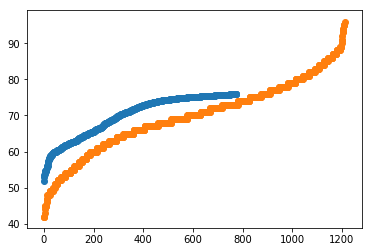

In [14]:
print(max(y_pred))

x = range(len(y_pred))
plt.scatter(x, np.sort(y_pred))

temp = train_data.sort_values(by=['y']).reset_index(drop=True)
x = range(len(temp["y"]))
plt.scatter(x, temp["y"])

In [ ]:
X_sel_incomplete= train_data[selected_feature_cols].values

train_mean_values = train_data.mean()
train_data_mean =  train_data.fillna(train_mean_values)
X_sel = train_data_mean[selected_feature_cols].values


#k = 10
X_sel =  KNN(k=k).fit_transform(X_sel_incomplete)

y_sel = train_data["y"].values

X_sel = RobustScaler(quantile_range=(10, 90)).fit_transform(X_sel)

score = cross_val_score(RandomForestRegressor(n_jobs=-1, n_estimators=200), X_sel, y_sel, scoring='r2', cv=12)
print(score.mean())


#### Bayesian Optimization

In [ ]:
def svr_model(gamma, C, epsilon):
    score = cross_val_score(
                SVR(gamma=gamma, C=C, epsilon=epsilon, kernel='poly'), 
                X, y, scoring='r2').mean()
    #score = np.array(score)
    return score  

In [ ]:
# Bayesian Optimization

from bayes_opt import BayesianOptimization

bo = BayesianOptimization(svr_model,{'gamma': (0.01, 5.0), 'C': (0.1, 100), 'epsilon': (0.0001, 1)})

# Once we are satisfied with the initialization conditions
# we let the algorithm do its magic by calling the maximize()
# method.
bo.maximize(init_points=5, n_iter=15, kappa=10)

# The output values can be accessed with self.res
print(bo.res['max'])


In [ ]:
# Official Metric
score = r2_score(y, y_pred)

## Evaluation

## Submission

In [16]:
test_data["y"] = y_pred
util.data.write_submission(test_data, "nku")